In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
# Load all three files
print("Loading M5 data...")
sales_train = pd.read_csv('../data/raw/sales_train_validation.csv')
calendar = pd.read_csv('../data/raw/calendar.csv')
prices = pd.read_csv('../data/raw/sell_prices.csv')

print(f"Sales shape: {sales_train.shape}")
print(f"Calendar shape: {calendar.shape}")
print(f"Prices shape: {prices.shape}")

Loading M5 data...
Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [3]:
print("CALCULATING PRODUCT STATISTICS")
print("="*60)

# Get sales columns
sales_cols = [col for col in sales_train.columns if col.startswith('d_')]
print(f"Total days: {len(sales_cols)}")

# Calculate statistics for each product (row)
stats = []

for idx, row in sales_train.iterrows():
    # Get sales values
    sales_values = row[sales_cols].values
    
    # Calculate metrics
    total_sales = sales_values.sum()
    mean_sales = sales_values.mean()
    std_sales = sales_values.std()
    cv = std_sales / mean_sales if mean_sales > 0 else 999  # Avoid division by zero
    zero_pct = (sales_values == 0).sum() / len(sales_values) * 100
    
    stats.append({
        'id': row['id'],
        'item_id': row['item_id'],
        'dept_id': row['dept_id'],
        'cat_id': row['cat_id'],
        'store_id': row['store_id'],
        'state_id': row['state_id'],
        'total_sales': total_sales,
        'mean_sales': mean_sales,
        'std_sales': std_sales,
        'cv': cv,
        'zero_pct': zero_pct
    })
    
    # Progress indicator
    if (idx + 1) % 5000 == 0:
        print(f"Processed {idx + 1}/{len(sales_train)} products...")

# Convert to DataFrame
stats_df = pd.DataFrame(stats)
print(f"\n✅ Statistics calculated for {len(stats_df)} products!")
print("\nFirst few rows:")
print(stats_df.head())

CALCULATING PRODUCT STATISTICS
Total days: 1913
Processed 5000/30490 products...
Processed 10000/30490 products...
Processed 15000/30490 products...
Processed 20000/30490 products...
Processed 25000/30490 products...
Processed 30000/30490 products...

✅ Statistics calculated for 30490 products!

First few rows:
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  total_sales  mean_sales  std_sales        cv   zero_pct  
0       CA          600    0.313643   0.685071  2.184235  77.992682  
1       CA          493    0.257710   0.569273  2.208963  78.98588

In [4]:
print("CALCULATING AVERAGE PRICES")
print("="*60)

# Calculate average price per item-store
avg_prices = prices.groupby(['store_id', 'item_id'])['sell_price'].mean().reset_index()
avg_prices.columns = ['store_id', 'item_id', 'avg_price']

print(f"Average prices calculated for {len(avg_prices)} store-item combinations")

# Merge with stats
stats_df = stats_df.merge(avg_prices, on=['store_id', 'item_id'], how='left')

# Fill missing prices with median
stats_df['avg_price'] = stats_df['avg_price'].fillna(stats_df['avg_price'].median())

# Calculate total revenue
stats_df['total_revenue'] = stats_df['total_sales'] * stats_df['avg_price']

print("\n✅ Prices added!")
print(stats_df[['id', 'total_sales', 'avg_price', 'total_revenue']].head())

CALCULATING AVERAGE PRICES
Average prices calculated for 30490 store-item combinations

✅ Prices added!
                              id  total_sales  avg_price  total_revenue
0  HOBBIES_1_001_CA_1_validation          600   8.285714    4971.428571
1  HOBBIES_1_002_CA_1_validation          493   3.970000    1957.210000
2  HOBBIES_1_003_CA_1_validation          288   2.970000     855.360000
3  HOBBIES_1_004_CA_1_validation         3288   4.528448   14889.535884
4  HOBBIES_1_005_CA_1_validation         1849   2.940902    5437.728271


ABC CLASSIFICATION (Revenue)

📊 ABC Distribution:

Category A: 11163 products (36.6%)
  → Revenue: $150,717,398 (80.0%)

Category B: 9404 products (30.8%)
  → Revenue: $28,261,129 (15.0%)

Category C: 9923 products (32.5%)
  → Revenue: $9,421,766 (5.0%)


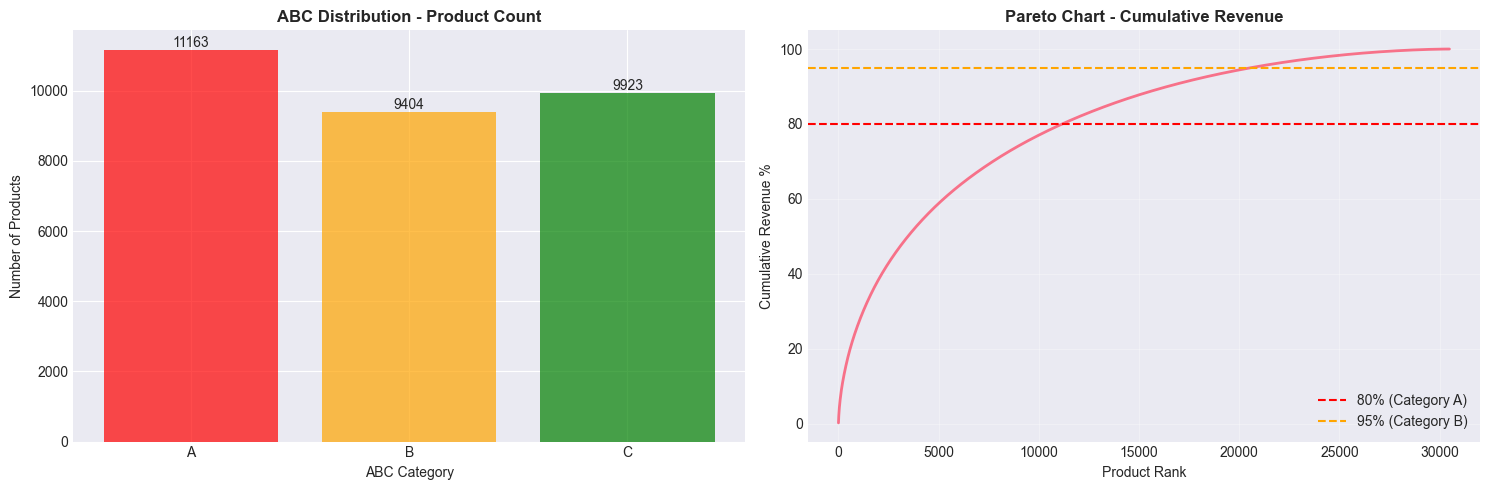

In [5]:
print("ABC CLASSIFICATION (Revenue)")
print("="*60)

# Sort by revenue (descending)
stats_df = stats_df.sort_values('total_revenue', ascending=False).reset_index(drop=True)

# Calculate cumulative revenue percentage
stats_df['cumulative_revenue'] = stats_df['total_revenue'].cumsum()
total_revenue = stats_df['total_revenue'].sum()
stats_df['cumulative_revenue_pct'] = (stats_df['cumulative_revenue'] / total_revenue) * 100

# Assign ABC categories
def assign_abc(cum_pct):
    if cum_pct <= 80:
        return 'A'
    elif cum_pct <= 95:
        return 'B'
    else:
        return 'C'

stats_df['ABC'] = stats_df['cumulative_revenue_pct'].apply(assign_abc)

# Show distribution
abc_counts = stats_df['ABC'].value_counts().sort_index()
abc_revenue = stats_df.groupby('ABC')['total_revenue'].sum()
abc_revenue_pct = (abc_revenue / total_revenue * 100).round(2)

print("\n📊 ABC Distribution:")
print(f"\nCategory A: {abc_counts['A']} products ({abc_counts['A']/len(stats_df)*100:.1f}%)")
print(f"  → Revenue: ${abc_revenue['A']:,.0f} ({abc_revenue_pct['A']:.1f}%)")

print(f"\nCategory B: {abc_counts['B']} products ({abc_counts['B']/len(stats_df)*100:.1f}%)")
print(f"  → Revenue: ${abc_revenue['B']:,.0f} ({abc_revenue_pct['B']:.1f}%)")

print(f"\nCategory C: {abc_counts['C']} products ({abc_counts['C']/len(stats_df)*100:.1f}%)")
print(f"  → Revenue: ${abc_revenue['C']:,.0f} ({abc_revenue_pct['C']:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
axes[0].bar(abc_counts.index, abc_counts.values, color=['red', 'orange', 'green'], alpha=0.7)
axes[0].set_xlabel('ABC Category')
axes[0].set_ylabel('Number of Products')
axes[0].set_title('ABC Distribution - Product Count', fontweight='bold')
for i, v in enumerate(abc_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Pareto chart
axes[1].plot(range(len(stats_df)), stats_df['cumulative_revenue_pct'], linewidth=2)
axes[1].axhline(y=80, color='red', linestyle='--', label='80% (Category A)')
axes[1].axhline(y=95, color='orange', linestyle='--', label='95% (Category B)')
axes[1].set_xlabel('Product Rank')
axes[1].set_ylabel('Cumulative Revenue %')
axes[1].set_title('Pareto Chart - Cumulative Revenue', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


XYZ CLASSIFICATION (Demand Variability)

📊 XYZ Distribution:

Category X (CV < 0.5): 77 products (0.3%)
  → Stable, predictable demand

Category Y (0.5 ≤ CV < 1.5): 8143 products (26.7%)
  → Moderate variability

Category Z (CV ≥ 1.5): 22270 products (73.0%)
  → Erratic, unpredictable demand

📈 CV Statistics:
count    30490.000000
mean         2.385710
std          1.313999
min          0.253066
25%          1.458850
50%          2.048649
75%          2.969554
max         23.026677
Name: cv, dtype: float64


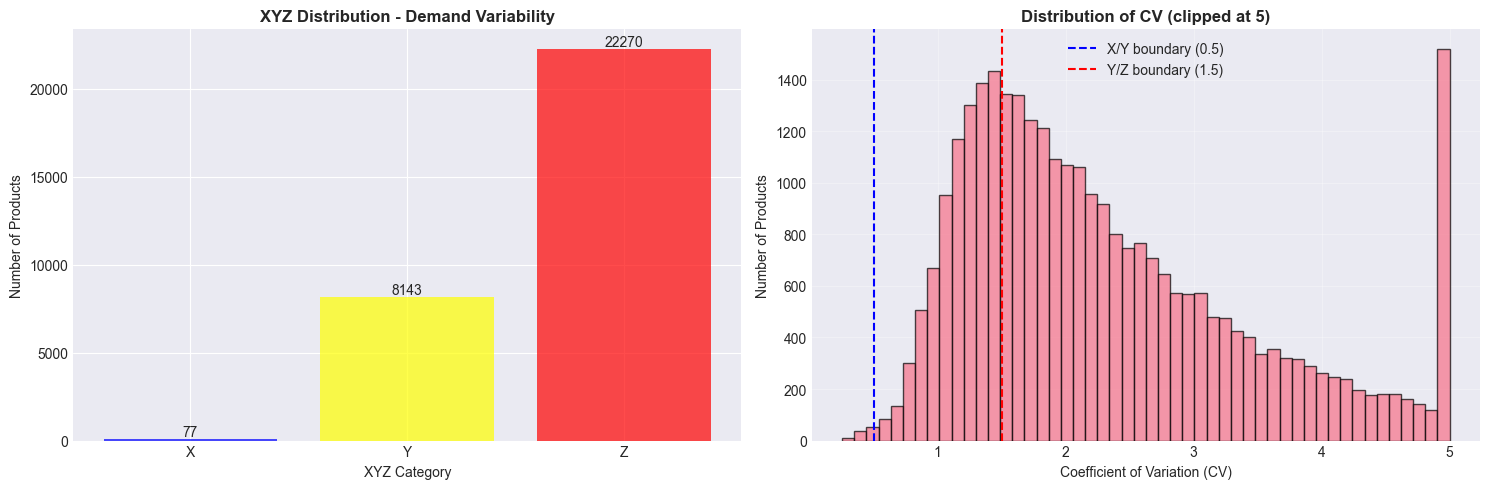

In [6]:
print("XYZ CLASSIFICATION (Demand Variability)")
print("="*60)

# Assign XYZ categories based on CV
def assign_xyz(cv):
    if cv < 0.5:
        return 'X'
    elif cv < 1.5:
        return 'Y'
    else:
        return 'Z'

stats_df['XYZ'] = stats_df['cv'].apply(assign_xyz)

# Show distribution
xyz_counts = stats_df['XYZ'].value_counts().sort_index()

print("\n📊 XYZ Distribution:")
print(f"\nCategory X (CV < 0.5): {xyz_counts.get('X', 0)} products ({xyz_counts.get('X', 0)/len(stats_df)*100:.1f}%)")
print(f"  → Stable, predictable demand")

print(f"\nCategory Y (0.5 ≤ CV < 1.5): {xyz_counts.get('Y', 0)} products ({xyz_counts.get('Y', 0)/len(stats_df)*100:.1f}%)")
print(f"  → Moderate variability")

print(f"\nCategory Z (CV ≥ 1.5): {xyz_counts.get('Z', 0)} products ({xyz_counts.get('Z', 0)/len(stats_df)*100:.1f}%)")
print(f"  → Erratic, unpredictable demand")

# CV distribution
print(f"\n📈 CV Statistics:")
print(stats_df['cv'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
axes[0].bar(xyz_counts.index, xyz_counts.values, color=['blue', 'yellow', 'red'], alpha=0.7)
axes[0].set_xlabel('XYZ Category')
axes[0].set_ylabel('Number of Products')
axes[0].set_title('XYZ Distribution - Demand Variability', fontweight='bold')
for i, (cat, v) in enumerate(xyz_counts.items()):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Histogram of CV
axes[1].hist(stats_df['cv'].clip(upper=5), bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.5, color='blue', linestyle='--', label='X/Y boundary (0.5)')
axes[1].axvline(x=1.5, color='red', linestyle='--', label='Y/Z boundary (1.5)')
axes[1].set_xlabel('Coefficient of Variation (CV)')
axes[1].set_ylabel('Number of Products')
axes[1].set_title('Distribution of CV (clipped at 5)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ABC-XYZ MATRIX (9 Segments)

📊 ABC-XYZ Matrix (Product Counts):
XYZ   X     Y      Z    All
ABC                        
A    77  7092   3994  11163
B     0  1025   8379   9404
C     0    26   9897   9923
All  77  8143  22270  30490

📊 ABC-XYZ Matrix (% Distribution):
XYZ     X      Y      Z
ABC                    
A    0.25  23.26  13.10
B    0.00   3.36  27.48
C    0.00   0.09  32.46

💰 Revenue by Segment:
XYZ             X             Y             Z
ABC                                          
A    5.787774e+06  1.108235e+08  3.410611e+07
B    0.000000e+00  3.632187e+06  2.462894e+07
C    0.000000e+00  4.151346e+04  9.380253e+06


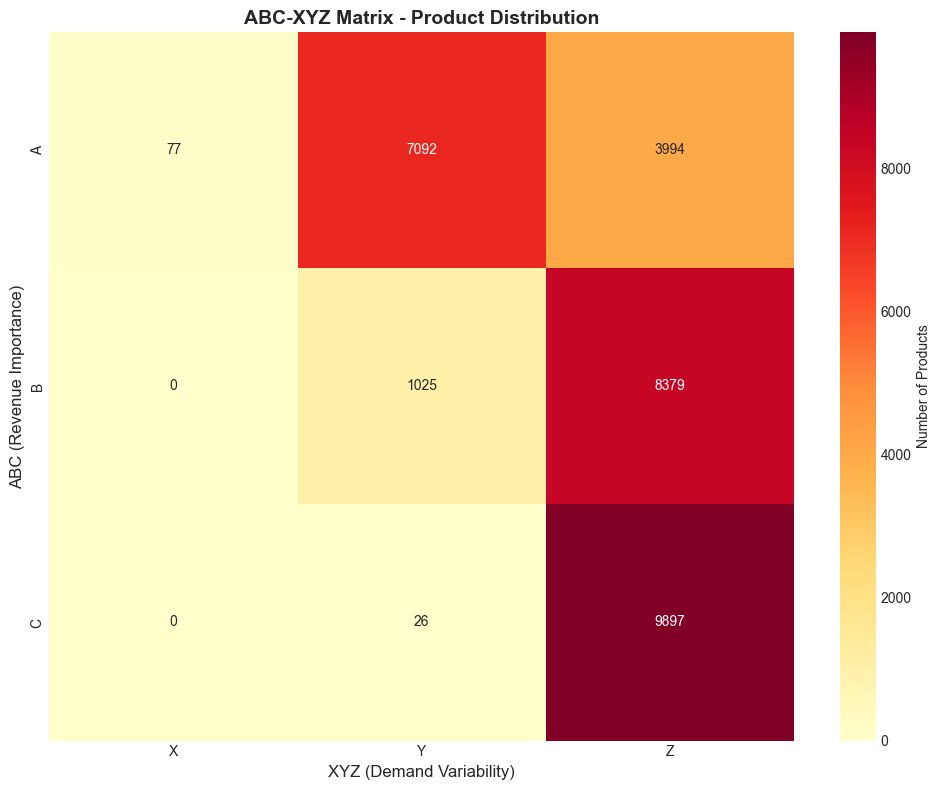


SAMPLE PRODUCTS FROM EACH SEGMENT

AX Segment (77 products):
                         id  total_revenue  mean_sales       cv  zero_pct
FOODS_3_586_TX_2_validation  307756.454255  100.802405 0.306256  0.418191
FOODS_3_586_TX_3_validation  239588.323830   78.474647 0.320502  0.365917
FOODS_3_586_CA_3_validation  214426.682837   70.248824 0.253066  0.261370

AY Segment (7092 products):
                         id  total_revenue  mean_sales       cv  zero_pct
FOODS_3_120_CA_3_validation  441813.034783   46.416623 0.982238 34.657606
FOODS_3_090_CA_3_validation  337582.535674  130.947203 0.829215 18.766336
FOODS_3_120_CA_1_validation  308257.020000   32.357031 1.036427 34.866702

AZ Segment (3994 products):
                           id  total_revenue  mean_sales       cv  zero_pct
HOBBIES_1_354_TX_3_validation  261859.341017    5.902248 1.900964 73.653947
HOBBIES_1_158_TX_3_validation  194249.940000    4.418714 2.027349 77.208573
HOBBIES_1_354_TX_2_validation  132041.739070    2.967590 1.8

In [7]:
print("ABC-XYZ MATRIX (9 Segments)")
print("="*60)

# Create combined category
stats_df['ABC_XYZ'] = stats_df['ABC'] + stats_df['XYZ']

# Cross-tabulation
matrix = pd.crosstab(stats_df['ABC'], stats_df['XYZ'], margins=True)
print("\n📊 ABC-XYZ Matrix (Product Counts):")
print(matrix)

# Percentage distribution
matrix_pct = pd.crosstab(stats_df['ABC'], stats_df['XYZ'], normalize='all') * 100
print("\n📊 ABC-XYZ Matrix (% Distribution):")
print(matrix_pct.round(2))

# Revenue by segment
revenue_matrix = stats_df.groupby(['ABC', 'XYZ'])['total_revenue'].sum().unstack(fill_value=0)
print("\n💰 Revenue by Segment:")
print(revenue_matrix)

# Visualize the matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Heatmap
matrix_for_plot = pd.crosstab(stats_df['ABC'], stats_df['XYZ'])
sns.heatmap(matrix_for_plot, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Products'}, ax=ax)

ax.set_title('ABC-XYZ Matrix - Product Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('XYZ (Demand Variability)', fontsize=12)
ax.set_ylabel('ABC (Revenue Importance)', fontsize=12)

# Add segment descriptions
descriptions = {
    'AX': '🌟 Golden\nZone',
    'AY': 'Important\nModerate',
    'AZ': 'High Value\nErratic',
    'BX': 'Standard\nStable',
    'BY': '🎯 Most\nCommon',
    'BZ': 'Mid Value\nTricky',
    'CX': 'Low Value\nEasy',
    'CY': 'Low Value\nAcceptable',
    'CZ': '⚠️ Consider\nDiscontinue'
}

plt.tight_layout()
plt.show()

# Show examples from each segment
print("\n" + "="*60)
print("SAMPLE PRODUCTS FROM EACH SEGMENT")
print("="*60)

for segment in ['AX', 'AY', 'AZ', 'BY', 'BZ', 'CZ']:
    segment_data = stats_df[stats_df['ABC_XYZ'] == segment]
    if len(segment_data) > 0:
        print(f"\n{segment} Segment ({len(segment_data)} products):")
        sample = segment_data.head(3)[['id', 'total_revenue', 'mean_sales', 'cv', 'zero_pct']]
        print(sample.to_string(index=False))

In [8]:
print("MODEL RECOMMENDATIONS BY SEGMENT")
print("="*60)

# Define model strategy
model_strategy = {
    'AX': {
        'model': 'Prophet or ARIMA',
        'update_freq': 'Daily',
        'service_level': '98%',
        'safety_stock': 'Low (1-2 weeks)',
        'priority': '🔴 Critical'
    },
    'AY': {
        'model': 'Prophet or LightGBM',
        'update_freq': 'Daily',
        'service_level': '97%',
        'safety_stock': 'Medium (2-3 weeks)',
        'priority': '🔴 Critical'
    },
    'AZ': {
        'model': 'TFT or Ensemble',
        'update_freq': 'Daily',
        'service_level': '95%',
        'safety_stock': 'High (4-6 weeks)',
        'priority': '🔴 Critical'
    },
    'BX': {
        'model': 'ARIMA or Prophet',
        'update_freq': 'Weekly',
        'service_level': '95%',
        'safety_stock': 'Low (1-2 weeks)',
        'priority': '🟡 Important'
    },
    'BY': {
        'model': 'LightGBM',
        'update_freq': 'Weekly',
        'service_level': '92%',
        'safety_stock': 'Medium (2-4 weeks)',
        'priority': '🟡 Important'
    },
    'BZ': {
        'model': 'LightGBM',
        'update_freq': 'Weekly',
        'service_level': '90%',
        'safety_stock': 'High (4-6 weeks)',
        'priority': '🟡 Important'
    },
    'CX': {
        'model': 'Simple Average',
        'update_freq': 'Monthly',
        'service_level': '90%',
        'safety_stock': 'Low',
        'priority': '🟢 Low'
    },
    'CY': {
        'model': 'Simple Average',
        'update_freq': 'Monthly',
        'service_level': '88%',
        'safety_stock': 'Medium',
        'priority': '🟢 Low'
    },
    'CZ': {
        'model': 'None or Simple Avg',
        'update_freq': 'Monthly or None',
        'service_level': '85%',
        'safety_stock': 'High or Discontinue',
        'priority': '⚠️ Consider discontinuing'
    }
}

# Display strategy
strategy_df = pd.DataFrame(model_strategy).T
print("\n" + strategy_df.to_string())

# Add strategy to main dataframe
stats_df['model_recommendation'] = stats_df['ABC_XYZ'].map(
    {k: v['model'] for k, v in model_strategy.items()}
)

print("\n✅ Model recommendations added to dataframe!")

MODEL RECOMMENDATIONS BY SEGMENT

                  model      update_freq service_level         safety_stock                   priority
AX     Prophet or ARIMA            Daily           98%      Low (1-2 weeks)                 🔴 Critical
AY  Prophet or LightGBM            Daily           97%   Medium (2-3 weeks)                 🔴 Critical
AZ      TFT or Ensemble            Daily           95%     High (4-6 weeks)                 🔴 Critical
BX     ARIMA or Prophet           Weekly           95%      Low (1-2 weeks)                🟡 Important
BY             LightGBM           Weekly           92%   Medium (2-4 weeks)                🟡 Important
BZ             LightGBM           Weekly           90%     High (4-6 weeks)                🟡 Important
CX       Simple Average          Monthly           90%                  Low                      🟢 Low
CY       Simple Average          Monthly           88%               Medium                      🟢 Low
CZ   None or Simple Avg  Monthly or Non

In [9]:
print("SAVING SEGMENTED DATA")
print("="*60)

# Save to processed folder
output_path = '../data/processed/products_segmented.csv'
stats_df.to_csv(output_path, index=False)

print(f"✅ Saved to: {output_path}")
print(f"Total products: {len(stats_df)}")
print(f"Columns: {list(stats_df.columns)}")

# Quick summary
print("\n📊 Final Summary:")
print(f"Total Revenue: ${stats_df['total_revenue'].sum():,.0f}")
print(f"\nSegment breakdown:")
print(stats_df['ABC_XYZ'].value_counts().sort_index())

SAVING SEGMENTED DATA
✅ Saved to: ../data/processed/products_segmented.csv
Total products: 30490
Columns: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'total_sales', 'mean_sales', 'std_sales', 'cv', 'zero_pct', 'avg_price', 'total_revenue', 'cumulative_revenue', 'cumulative_revenue_pct', 'ABC', 'XYZ', 'ABC_XYZ', 'model_recommendation']

📊 Final Summary:
Total Revenue: $188,400,294

Segment breakdown:
ABC_XYZ
AX      77
AY    7092
AZ    3994
BY    1025
BZ    8379
CY      26
CZ    9897
Name: count, dtype: int64
